In [560]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

#from scipy.special import erf, erfinv
#_gauss   = lambda x, p, sigma: 1./np.sqrt(2*np.pi)/sigma*np.exp(-(x-p)**2/2/sigma**2)
#_cdf     = lambda x, u, bw: .5 * (1+erf((x-u)/np.sqrt(2)/bw))
#_derfinv = lambda x: 0.5*np.sqrt(np.pi)*np.exp((erfinv(x))**2)

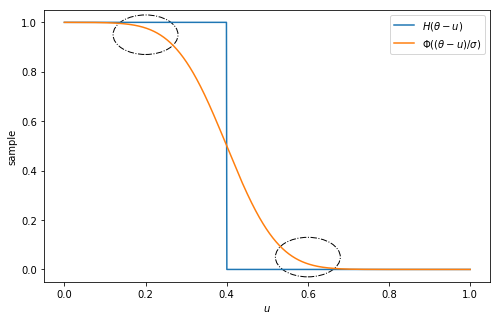

In [559]:
x = np.linspace(0,1,1000)
p, bw, pp =.4, .1, .05

plt.subplots(figsize=(8,5))
lns3 = plt.plot(x,np.heaviside(p-x,1), label = '$H(\\theta-u)$')
lns1 = plt.plot(x,_cdf(p-x,0,bw),label='$\Phi((\\theta-u)/\sigma)$')
plt.ylabel('sample')
plt.xlabel('$u$')
plt.gcf().gca().add_artist(plt.Circle((.2, .95), 0.08, ls='-.', color='k', fill=False))
plt.gcf().gca().add_artist(plt.Circle((.6, .05), 0.08, ls='-.',color='k', fill=False))

lns = lns3+lns1
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)#,loc=(.78,.77))
plt.savefig('31')
plt.show()

## 2

In [561]:
eps = 1e-7
erf    = lambda x: 2./tf.sqrt(np.pi) * (x - 1./3.*x**3)
erfinv = lambda x: tf.sqrt(np.pi) * (.5*x + 1./24.*np.pi*x**3)
cdf    = lambda x: .5*(1+tf.erf(x/tf.sqrt(2.)))

def jacobian(y_flat, x):
    n = y_flat.shape[0]
    loop_vars = [
        tf.constant(0, tf.int32),
        tf.TensorArray(tf.float32, size=n),
    ]
    _, jacobian = tf.while_loop(
        lambda j, _: j < n,
        lambda j, result: (j+1, result.write(j, tf.gradients(y_flat[j], x))),
        loop_vars)
    return tf.squeeze(jacobian.stack())

In [552]:
def mse(x,u0,u1,d,p,cp=False,cg=False):
    d  = 1./d
    
    w1 = p*(tf.exp(d*u0)-tf.exp(d*u1)) / (-tf.exp(d*(u0+u1)/2.)+tf.exp(d*u0))
    w1 = tf.clip_by_value(w1,0,1) if not cp else p
    w1 = w1 if not cg else tf.stop_gradient(w1)
    x1 = tf.clip_by_value(x,0,w1-eps)
    s1 = -(1./d*tf.log(x1/w1*(tf.exp(d*u1)-tf.exp(d*u0))+tf.exp(d*u0))-u0-u1)
    
    w0 = (tf.exp(d/2.*(u0+u1))-tf.exp(d*u1)) / (tf.exp(d*u0)-tf.exp(d*u1))
    w0 = (p-w0)/(1-w0)
    w0 = tf.clip_by_value(w0,0,1) if not cp else p
    w0 = w0 if not cg else tf.stop_gtadient(w0)
    x0 = tf.clip_by_value(x,w0+eps,1)
    s0 = 1./d*tf.log((x0-1)/(1-w0)*(tf.exp(d*u0)-tf.exp(d*u1))+tf.exp(d*u0))

    s1 = s1*tf.cast(x<w1,tf.float32) + u0*tf.cast(x>=w1,tf.float32)
    s0 = s0*tf.cast(x>w0,tf.float32) + u1*tf.cast(x<=w0,tf.float32)
    
    return s1*tf.cast(p>=.5,tf.float32) + s0*tf.cast(p<.5,tf.float32)

def msg(x,u0,u1,d,p,cp=False,cg=False):
    w1 = 2*p/(1+tf.erf((u0-u1)/d/2./np.sqrt(2.)))
    w1 = tf.clip_by_value(w1,0,1) if not cp else p
    w1 = w1 if not cg else tf.stop_gradient(w1)
    
    s1 = u1 + tf.sqrt(2.)*d * erfinv((2*x)/w1-1)
    
    w0 = 1+tf.erf((u1-u0)/d/2./tf.sqrt(2.))
    w0 = (p-w0/2.)/(1-w0/2.)
    w0 = tf.clip_by_value(w0,0,1) if not cp else p
    w0 = w0 if not cg else tf.stop_gradient(w0)

    s0 = u0 + tf.sqrt(2.)*d * erfinv(2*(x-1)/(1-w0)+1)
    
    s1 = s1*tf.cast(x<w1,tf.float32) + u0*tf.cast(x>=w1,tf.float32)
    s0 = s0*tf.cast(x>w0,tf.float32) + u1*tf.cast(x<=w0,tf.float32)
    return s1*tf.cast(p>=.5,tf.float32) + s0*tf.cast(p<.5,tf.float32)

In [553]:
def plot_f1(s, n, fn, u, *args):
    p = np.linspace(.01,.99,n)
    fig,ax = plt.subplots(2,2,figsize=(16,10))
    ax[0][0].set_ylabel('$|\{\Phi|\Phi>0.5\}| / N$')
    ax[0][1].set_ylabel('$bias(\{\Phi|0.05<\Phi<0.95\})$')
    ax[1][0].set_ylabel('$mean(d\Phi/d\\theta)$')
    ax[1][1].set_ylabel('$variance(d\Phi/d\\theta)$')            

    for f in args:
        ax[0][0].plot(p,f[0])
        ax[0][1].plot(p,f[1])
        ax[1][0].plot(p,f[2])
        ax[1][1].plot(p,f[3])

    for i in range(2):
        for j in range(2):   
            ax[i][j].set_xlabel('$\\theta$')
            ax[i][j].legend([f[4] for f in args],loc=(0.01,u[0]))

    if s:
        ax[0][1].set_ylim(u[1])
        ax[1][0].set_ylim(u[2])
        ax[1][1].set_ylim(u[3])
        plt.savefig(fn)
    plt.show()
    
def sim1_plot(d,g):
    f1 = np.mean(d>=.5,1)
    f2 = (1-d)*(d>=.5) + d*(d<.5)
    f2 = np.sum(f2*(f2>.05),1)/np.sum(f2>.05,1)
    f3 = np.mean(g,0)
    f4 = np.std(g,0)**2
    return f1,f2,f3,f4

In [554]:
def sim1():
    with tf.Graph().as_default():
        n = 1000
        
        bw= .1        
        u = tf.lin_space(0.,1.,n)
        p = tf.reshape(tf.lin_space(.01,.99,99),[-1,1])
        du = cdf((p-u)/bw)
        gu = jacobian(tf.transpose(du),p)

        bw, k, b = .2, .25, .15
        s = mse(u,tf.stop_gradient(p+k),tf.stop_gradient(p-k),b,p)
        dmse = cdf((p-s)/bw)        
        gmse = jacobian(tf.transpose(dmse),p)

        bw, k, b = .2, .25, .15
        ss = msg(u,tf.stop_gradient(p+k),tf.stop_gradient(p-k),b,p)
        dmsg = cdf((p-ss)/bw)
        gmsg = jacobian(tf.transpose(dmsg),p)
        
        with tf.Session() as sess:
            g1,d1 = sess.run([gu,du])
            g2,d2 = sess.run([gmse,dmse])
            g3,d3 = sess.run([gmsg,dmsg])            
            return sim1_plot(d1,g1),sim1_plot(d2,g2),sim1_plot(d3,g3)

f = sim1()        

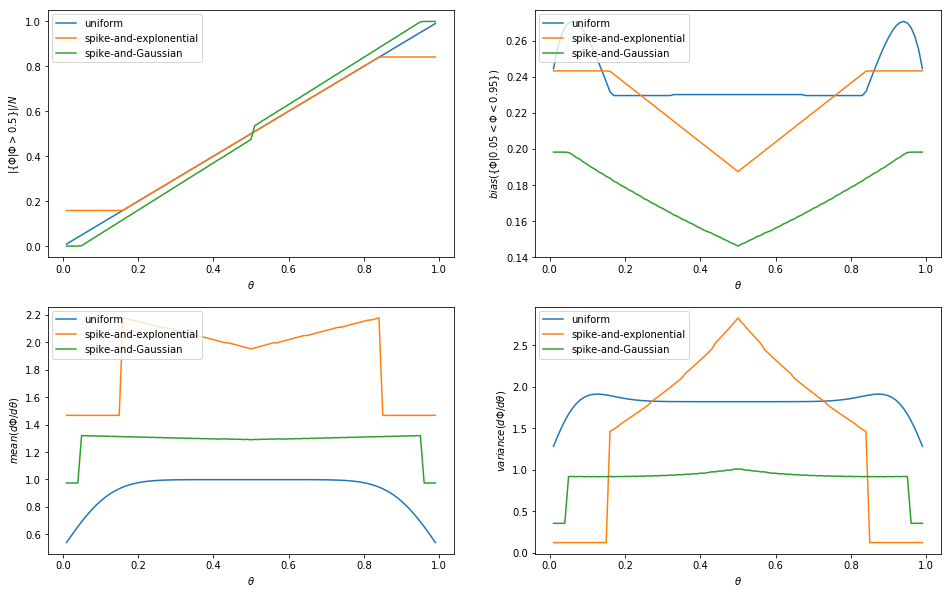

In [555]:
plot_f1(False,99,'32',(.79,(.14,.32),(.4,2.8),(0,3)), 
       f[0]+tuple(['uniform']),
       f[1]+tuple(['spike-and-explonential']),
       f[2]+tuple(['spike-and-Gaussian']))

## 3

In [541]:
def mse2(x,u0,u1,d,p,cp=False,cg=False):
    d  = 1./d
    
    w1 = p*(tf.exp(d*u0)-tf.exp(d*u1)) / (-tf.exp(d*(u0+u1-p))+tf.exp(d*u0))
    w1 = tf.clip_by_value(w1,0,1) if not cp else p
    w1 = w1 if not cg else tf.stop_gradient(w1)
    x1 = tf.clip_by_value(x,0,w1-eps)
    s1 = -(1./d*tf.log(x1/w1*(tf.exp(d*u1)-tf.exp(d*u0))+tf.exp(d*u0))-u0-u1)
    
    w0 = (tf.exp(d*p)-tf.exp(d*u1)) / (tf.exp(d*u0)-tf.exp(d*u1))
    w0 = (p-w0)/(1-w0)
    w0 = tf.clip_by_value(w0,0,1) if not cp else p
    w0 = w0 if not cg else tf.stop_gtadient(w0)
    x0 = tf.clip_by_value(x,w0+eps,1)
    s0 = 1./d*tf.log((x0-1)/(1-w0)*(tf.exp(d*u0)-tf.exp(d*u1))+tf.exp(d*u0))

    s1 = s1*tf.cast(x<w1,tf.float32) + u0*tf.cast(x>=w1,tf.float32)
    s0 = s0*tf.cast(x>w0,tf.float32) + u1*tf.cast(x<=w0,tf.float32)
    
    return s1*tf.cast(p>=.5,tf.float32) + s0*tf.cast(p<.5,tf.float32)

def msg2(x,u0,u1,d,p,cp=False,cg=False):
    w1 = 2*p/(1+tf.erf((p-u1)/d/np.sqrt(2.)))
    w1 = tf.clip_by_value(w1,0,1) if not cp else p
    w1 = w1 if not cg else tf.stop_gradient(w1)
    
    s1 = u1 + tf.sqrt(2.)*d * erfinv((2*x)/w1-1)
    
    w0 = 1+tf.erf((p-u0)/d/tf.sqrt(2.))
    w0 = (p-w0/2.)/(1-w0/2.)
    w0 = tf.clip_by_value(w0,0,1) if not cp else p
    w0 = w0 if not cg else tf.stop_gtadient(w0)

    s0 = u0 + tf.sqrt(2.)*d * erfinv(2*(x-1)/(1-w0)+1)
    
    s1 = s1*tf.cast(x<w1,tf.float32) + u0*tf.cast(x>=w1,tf.float32)
    s0 = s0*tf.cast(x>w0,tf.float32) + u1*tf.cast(x<=w0,tf.float32)
    return s1*tf.cast(p>=.5,tf.float32) + s0*tf.cast(p<.5,tf.float32)

In [497]:
def sim2():
    with tf.Graph().as_default():
        n = 100000
        u0, u1 = 1., 0.
        u = tf.random_uniform([n])
        p = tf.reshape(tf.lin_space(.01,.49,49),[-1,1])

        sigma0, beta0 = tf.constant(.33), tf.constant(.33)
        sigma = tf.Variable(tf.ones([49,1])*sigma0)
        beta  = tf.Variable(tf.ones([49,1])*beta0)

        s  = msg2(u,u0,u1, beta, p)
        ss = msg2(u,u0,u1,beta0,.5)
        d  = ((cdf((p-s)/sigma)-cdf((.5-ss)/sigma0))*s)**2

        opt = tf.train.GradientDescentOptimizer(.01)
        tr  = opt.minimize(tf.reduce_sum(tf.reduce_mean(d,1)))

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())        
            sigma_rec = []
            beta_rec  = []
            loss_rec  = []
            for i in xrange(100):
                _, sigma_, beta_, d_, ss = sess.run([tr,sigma,beta,d, s])
                sigma_rec.append(sigma_)
                beta_rec.append(beta_)
                loss_rec.append(d_)
                if i%10==0:
                    print i,                
            return sigma_rec, beta_rec, loss_rec

f = sim2()

0 10 20 30 40 50 60 70 80 90


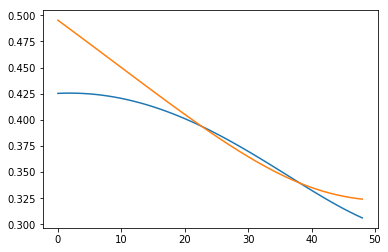

In [535]:
# mse
msef = f2
plt.plot(f2[0][-1])
plt.plot(f2[1][-1])
plt.show()

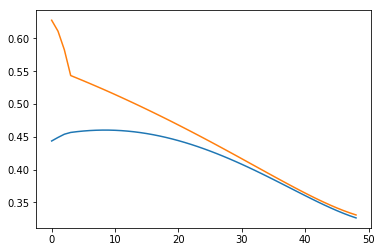

In [536]:
# msg
msgf=f
plt.plot(f[0][-1])
plt.plot(f[1][-1])
plt.show()

In [ ]:
def sim22():
    with tf.Graph().as_default():
        n = 1000
        u = tf.lin_space(0,1,n)
        p = tf.reshape(tf.lin_space(.01,.49,49),[-1,1])

        sigma0 = tf.constant(.33)
        beta0  = tf.constant(.33)
        
        sigma = tf.lin_space(.15,.55,5)
        dmsg = msg(u, 1, 0, beta0, p)
        d = cdf((.5-dmsg)/sigma0) - cdf((p-dmsg)/sigma)
        r = tf.reduce_mean(d**2 * dmsg, 1)

        beta = tf.lin_space(.23,.63,5)
        dmsg2 = msg(u, 1, 0, beta, p)
        d2 = cdf((.5-dmsg2)/sigma0) - cdf((p-dmsg)/sigma)
        r2 = tf.reduce_mean(d2**2 * dmsg2, 1)
        
        with tf.Session() as sess:
            return sess.run([r,r2])

a1 = sim22()

In [ ]:
def plot_f2(i,a1,ax):
    ctr = 0
    x = np.linspace(.01,.49,49)
    for z in a1:
        ctr = ctr+1
        for zz in z:
            if ctr<=5:
                ax[i][0].plot(x,zz)
            else:
                ax[i][1].plot(x,zz)
    ax[i][0].plot(x,a1[-1][-1],c='0',ls='-.')
    ax[i][1].plot(x,a1[-1][-1],c='0',ls='-.')

    ax[i][0].legend(['$\sigma=0.1$','$\sigma=0.2$','$\sigma=0.3$','$\sigma=0.4$','$\sigma=0.5$'])
    ax[i][1].legend(['$\\beta^{-1}=0.2$','$\\beta^{-1}=0.25$','$\\beta^{-1}=0.3$',
                     '$\\beta^{-1}=0.35$','$\\beta^{-1}=0.4$'])
    ax[i][0].set_xlabel('$\\theta$')
    ax[i][1].set_xlabel('$\\theta$')
    ax[i][0].set_ylabel('$E[(\Phi((\\theta-u)/\sigma)-\Phi((0.5-u)/\sigma_0))^2]$')
    ax[i][1].set_ylabel('$E[(\Phi((\\theta-u)/\sigma)-\Phi((0.5-u)/\sigma_0))^2]$')

fig,ax = plt.subplots(2,2,figsize=(16,10)) 
plot_f2(0,a1,ax)
plt.savefig('33')
plt.show()

## 3-2

In [531]:
def sim3():
    with tf.Graph().as_default():
        n = 1000
        u0, u1 = 1, 0
        
        u = tf.lin_space(0.,1.,n)
        p = tf.reshape(tf.lin_space(.01,.99,99),[-1,1])
        du = cdf((p-u)/.1)
        gu = jacobian(tf.transpose(du),p)


        beta  = tf.concat([f2[1][-1],[[.31]],f2[1][-1][::-1]],0)
        sigma = tf.concat([f2[0][-1],[[.315]],f2[0][-1][::-1]],0)
        s = mse2(u,u0,u1,beta,p)
        dmse = cdf((p-s)/sigma)
        gmse = jacobian(tf.transpose(dmse),p)

        beta  = np.concatenate([f[1][-1],[[.33]],f[1][-1][::-1]],0)
        sigma = np.concatenate([f[0][-1],[[.33]],f[0][-1][::-1]],0)
        ss = msg2(u,u0,u1,beta,p)
        dmsg = cdf((p-ss)/sigma)
        gmsg = jacobian(tf.transpose(dmsg),p)
        
        with tf.Session() as sess:
            g1,d1 = sess.run([gu,du])
            g2,d2 = sess.run([gmse,dmse])
            g3,d3 = sess.run([gmsg,dmsg])
            return sim1_plot(d1,g1),sim1_plot(d2,g2),sim1_plot(d3,g3)

f3 = sim3()        

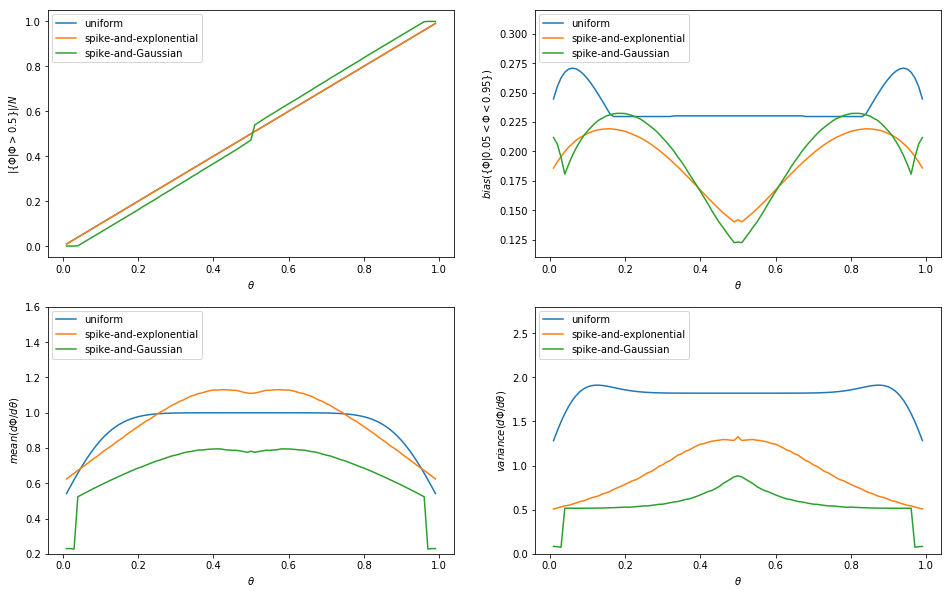

In [534]:
plot_f1(True, 99,'34',(.79,(.11,.32),(.2,1.6),(0,2.8)), 
       f3[0]+tuple(['uniform']),
       f3[1]+tuple(['spike-and-explonential']),
       f3[2]+tuple(['spike-and-Gaussian']))

## 3-3

##  4

In [118]:
gb1e3 = np.load('thesis_data/gb_1e3.npy')
gb3e4 = np.load('thesis_data/gb_3e4.npy')
sm1e3p05 = np.load('thesis_data/sm_1e3_p05.npy')
sm1e3p1 = np.load('thesis_data/sm_1e3_p1.npy')
sm1e3p2 = np.load('thesis_data/sm_1e3_p2.npy')
sm3e4p05 = np.load('thesis_data/sm_3e4_p05.npy')
sm3e4p1 = np.load('thesis_data/sm_3e4_p1.npy')
sm3e4p2 = np.load('thesis_data/sm_3e4_p2.npy')

In [143]:
def plot_data(errs, label, i, ax=None):
    ax = ax or plt
    if i==0:
        m = np.mean(errs[0], axis=0)
        line, = ax.plot(np.arange(1, len(m)+1), m, label=label, linewidth=3)
        m = np.mean(errs[1], axis=0)
        line, = ax.plot(np.arange(1, len(m)+1), m, label=label, linewidth=3, c=line.get_color(), ls='--')
    else:
        m = np.mean(errs[3][0], axis=0)
        line, = ax.plot(np.arange(1, len(m)+1), m, label=label, linewidth=3)

def plot_legend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    return leg

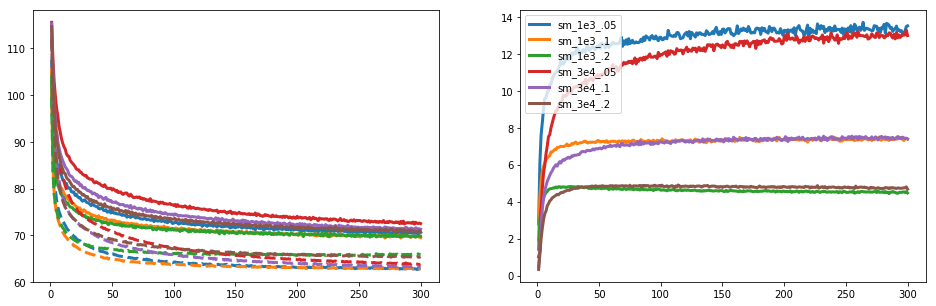

In [146]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

for i in range(2):
    plot_data(sm1e3p05, 'sm_1e3_.05',i, ax[i])
    plot_data(sm1e3p1,  'sm_1e3_.1',i, ax[i])
    plot_data(sm1e3p2,  'sm_1e3_.2',i, ax[i])
    plot_data(sm3e4p05, 'sm_3e4_.05',i, ax[i])
    plot_data(sm3e4p1,  'sm_3e4_.1',i, ax[i])
    plot_data(sm3e4p2,  'sm_3e4_.2',i, ax[i])
    
plot_legend(ax[1])
plt.show()

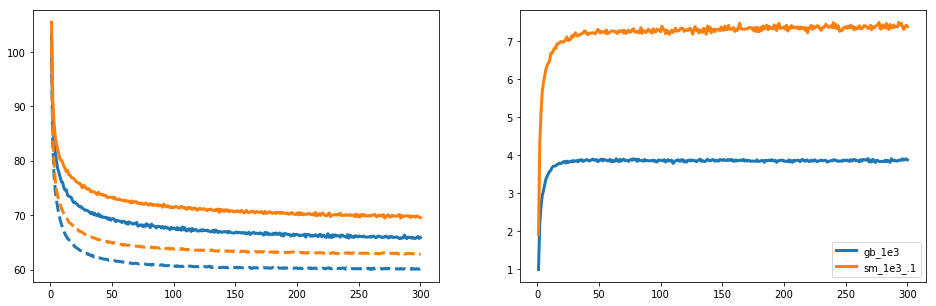

In [153]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
for i in xrange(2):
    plot_data(gb1e3, 'gb_1e3', i, ax[i])
#    plot_data(gb3e4, 'gb_3e4', i, ax[i])
    plot_data(sm1e3p1,  'sm_1e3_.1',i, ax[i])
    
plot_legend(ax[1])
plt.show()

In [ ]:
batch_xs = ngd_svrg[2]
batch_ys = ngd_svrg[3]
prdt = ngd_svrg[4]
bs = 1

fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[7,14]) for i in batch_xs]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[7,14]) for i in batch_ys]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), 1, 1), 0)
#dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in prdt]], 1)
#p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), bs, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
#ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
#ax[1].grid(False)
plt.show()